In [11]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import cartopy as cart
import cartopy.crs as ccrs
import cmocean.cm as cmo
import seaborn as sns
from glob import glob
import cartopy.feature as cfeature
import pandas as pd

from scipy import stats
import matplotlib.cm as cm
import matplotlib

from tqdm import tqdm

In [13]:
sim = xr.open_zarr('/storage/shared/oceanparcels/output_data/data_Claudio/set_19/set19_10.zarr/')
sim = sim.compute()

## Filter function

In [14]:
def filter_trajectories(data, condition):
    k, _ = np.where(condition)
    index = np.unique(k)
    
    data_relevant = data.where(data['trajectory'].isin(index), drop=True)

    return data_relevant

In [15]:
sim_surface = filter_trajectories(sim, sim['z']<10)

In [16]:
sim_surface

<xarray.Dataset>
Dimensions:           (traj: 10000, obs: 4856)
Dimensions without coordinates: traj, obs
Data variables: (12/19)
    Kz                (traj, obs) float32 5.271e-05 6.009e-05 ... nan nan
    abs_salinity      (traj, obs) float32 34.74 34.74 34.74 ... nan nan nan
    cons_temperature  (traj, obs) float32 0.7279 0.7254 0.7221 ... nan nan nan
    density           (traj, obs) float32 1.028e+03 1.028e+03 ... nan nan
    diameter          (traj, obs) float64 5.05e-08 5.05e-08 5.05e-08 ... nan nan
    in_motion         (traj, obs) float32 1.0 1.0 1.0 1.0 ... nan nan nan nan
    ...                ...
    u                 (traj, obs) float32 4.618e-07 4.043e-07 ... nan nan
    v                 (traj, obs) float32 -5.266e-07 -3.972e-07 ... nan nan
    v_s               (traj, obs) float32 0.0 4.756e-10 4.756e-10 ... nan nan
    w                 (traj, obs) float32 2.774e-05 -0.0003397 ... nan nan
    w_k               (traj, obs) float32 0.0 0.0 0.0 0.0 ... nan nan nan nan
    z                 (traj, obs) float64 5.1e+03 5.119e+03 ... nan nan
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        v2.3.0-303-gd31c5f32

## Continental shelf

In [17]:
shelf = filter_trajectories(sim, sim['seafloor'] < 200)

In [18]:
sim

<xarray.Dataset>
Dimensions:           (traj: 10000, obs: 4860)
Dimensions without coordinates: traj, obs
Data variables: (12/19)
    Kz                (traj, obs) float32 5.271e-05 6.009e-05 ... nan nan
    abs_salinity      (traj, obs) float32 34.74 34.74 34.74 ... nan nan nan
    cons_temperature  (traj, obs) float32 0.7279 0.7254 0.7221 ... nan nan nan
    density           (traj, obs) float32 1.028e+03 1.028e+03 ... nan nan
    diameter          (traj, obs) float64 5.05e-08 5.05e-08 5.05e-08 ... nan nan
    in_motion         (traj, obs) float32 1.0 1.0 1.0 1.0 ... nan nan nan nan
    ...                ...
    u                 (traj, obs) float32 4.618e-07 4.043e-07 ... nan nan
    v                 (traj, obs) float32 -5.266e-07 -3.972e-07 ... nan nan
    v_s               (traj, obs) float32 0.0 4.756e-10 4.756e-10 ... nan nan
    w                 (traj, obs) float32 2.774e-05 -0.0003397 ... nan nan
    w_k               (traj, obs) float32 0.0 0.0 0.0 0.0 ... nan nan nan nan
    z                 (traj, obs) float64 5.1e+03 5.119e+03 ... nan nan
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        v2.3.0-303-gd31c5f32

In [19]:
shp_dict = {}
files = glob('../data/ne_10m_bathymetry_all/*.shp')
assert len(files) > 0
files.sort()
for f in files:
    depth = f.split('_')[-1].split('.')[0]
    # depth = '-' + f.split('_')[-1].split('.')[0]
    # depths.append(depth)
    nei = cart.io.shapereader.Reader(f)
    shp_dict[depth] = nei

depths = [d for d in shp_dict.keys()][::-1]
colors = sns.mpl_palette('cmo.ice_r',n_colors=8)
cmap   = sns.mpl_palette('cmo.ice',n_colors=8,as_cmap=True)

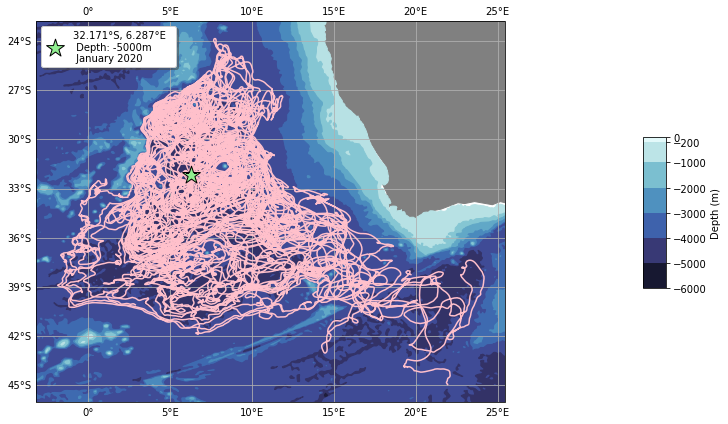

In [9]:
max_depth = -5500
min_depth = 0 

fig = plt.figure(figsize=(13,7))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent((-5, 20, -40, -25), crs=ccrs.PlateCarree())


i = 0
for depth in depths[:8]:
    ax.add_geometries(shp_dict[depth].geometries(),crs=ccrs.PlateCarree(),color=colors[i])
    i+=1

ax.add_feature(cart.feature.NaturalEarthFeature(category='physical',name='land',scale='110m'),color='grey',
              zorder=0)

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False

# Add custom colorbar
axi = fig.add_axes([0.910,0.35,0.025,0.3])
# axi = fig.add_axes([0.8,0.2,0.025,0.6])
norm = matplotlib.colors.Normalize(vmin=-6000,vmax=0)
cbar = matplotlib.colorbar.ColorbarBase(ax=axi,cmap=cmap,norm=norm,
        boundaries=(-np.array(depths[:8]).astype(int)).tolist()[::-1],
        ticks=-np.array(depths).astype(int),
        spacing='proportional',
        extend='neither',
        label='Depth (m)'
        )

ax.scatter(6.287, -32.171, marker='*',
           zorder=5, color='lightgreen', 
           label='32.171°S, 6.287°E  \n Depth: -5000m \n January 2020', 
           s=350,
          edgecolors='black')

ax.legend(loc='upper left', shadow=True, fontsize=10)
    
# frame = -1
# ax.plot(sim['lon'][8372,:], sim['lat'][8372,:], zorder=4, c='yellow')
# ax.scatter(shelf['lon'][:,:], shelf['lat'][:,:], zorder=5, c='red')
# ax.scatter(sim['lon'][8372,-10], sim['lat'][8372,-10], zorder=5, c='red')

# for t in range(shelf.dims['traj']):
#     ax.plot(shelf['lon'][t,:], shelf['lat'][t,:], c='pink')
#     ax.scatter(shelf['lon'][t,-1], shelf['lat'][t,-1], c='red', zorder=5)

for t in range(10):
    ax.plot(sim['lon'][t,:], sim['lat'][t,:], c='pink')
    ax.scatter(sim['lon'][t,-1], sim['lat'][t,-1], c='red', zorder=5)
    
    
# bar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.03])
# fig.colorbar(im, cax=bar_ax, orientation='horizontal', label='Particle diameter (m)')
# ax.set_title('10 years before sampling', fontsize=15, weight='bold')
# plt.savefig('../figs/revers.png')

In [10]:
frame= 1700

plt.bar(shelf['lon'][:,frame], shelf['seafloor'][:,frame]-shelf['z'][:,frame] ,bottom=-shelf['seafloor'][:,frame], color='blue')
plt.scatter(shelf['lon'][:,frame], -shelf['z'][:,frame], color='red', zorder=4)

IndexError: index 1700 is out of bounds for axis 1 with size 0

In [ ]:
max_depth = -6000
min_depth = 0 

fig = plt.figure(figsize=(8,6))
gs = fig.add_gridspec(2, 2,  width_ratios=(8, 2), height_ratios=(8, 2),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.07, hspace=0.07)

ax = plt.subplot(gs[0, 0], projection=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5)

i = 0
for depth in depths[:8]:
    ax.add_geometries(shp_dict[depth].geometries(),crs=ccrs.PlateCarree(),color=colors[i])
    i+=1

ax.add_feature(cart.feature.NaturalEarthFeature(category='physical',name='land',scale='110m'),color='grey',
              zorder=0)

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False

# Add custom colorbar
axi = fig.add_axes([0.78,0.4,0.025,0.4])
# axi = fig.add_axes([0.8,0.2,0.025,0.6])
norm = matplotlib.colors.Normalize(vmin=-6000,vmax=0)
cbar = matplotlib.colorbar.ColorbarBase(ax=axi,cmap=cmap,norm=norm,
        boundaries=(-np.array(depths[:8]).astype(int)).tolist()[::-1],
        ticks=-np.array(depths).astype(int),
        spacing='proportional',
        extend='neither',
        label='Depth (m)'
        )

ax.scatter(6.287, -32.171, marker='*',
           zorder=5, color='lightgreen', 
           label='32.171°S, 6.287°E  \n Depth: -5000m \n January 2020', 
           s=350, edgecolors='black')

# {shelf['time'][0, frame].values}
ax.set_title(f'-{frame} days')

frame = 1620
window = 30
if frame - window < 0:
    shadow = 0
    trail = frame
    
else:
    shadow = frame - window
    trail = window
    

im = ax.scatter(shelf['lon'][:,shadow:frame].T, shelf['lat'][:,shadow:frame].T, 
           c=-shelf['z'][:,shadow:frame].T, zorder=5, s=np.array([np.linspace(1, 41, trail)]*8).T, 
                cmap='OrRd',
               vmax=0, vmin=-5500)

im2 = ax.scatter(shelf['lon'][:,frame], shelf['lat'][:,frame], 
                c=shelf['diameter'][:,frame]*1000, 
                zorder=5, cmap='spring', norm=matplotlib.colors.LogNorm(),
               vmax=1e-2, vmin=1e-5, marker='s')

bar_ax = fig.add_axes([0.1, 0.18, 0.3, 0.03])
fig.colorbar(im, cax=bar_ax, orientation='horizontal', label='Particle depth (m)')

bar_ax2 = fig.add_axes([0.45, 0.18, 0.3, 0.03])
fig.colorbar(im2, cax=bar_ax2, orientation='horizontal', label='Particle diameter (mm)')
# ax.set_title('10 years before sampling', fontsize=15, weight='bold')
# plt.savefig('../figs/snapzhotz.png')

### Nanoparticles

In [10]:
nano = sim.where(sim.diameter < 1e-6, drop=True)

In [11]:
nano

<xarray.Dataset>
Dimensions:           (traj: 10000, obs: 4856)
Dimensions without coordinates: traj, obs
Data variables: (12/19)
    Kz                (traj, obs) float32 5.271e-05 6.009e-05 ... 1.226e-05
    abs_salinity      (traj, obs) float32 34.74 34.74 34.74 ... 34.79 34.79
    cons_temperature  (traj, obs) float32 0.7279 0.7254 0.7221 ... 1.297 1.298
    density           (traj, obs) float32 1.028e+03 1.028e+03 ... 1.028e+03
    diameter          (traj, obs) float64 5.05e-08 5.05e-08 ... 1.017e-07
    in_motion         (traj, obs) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    ...                ...
    u                 (traj, obs) float32 4.618e-07 4.043e-07 ... 2.168e-08
    v                 (traj, obs) float32 -5.266e-07 -3.972e-07 ... 1.367e-07
    v_s               (traj, obs) float32 0.0 4.756e-10 ... 1.93e-09 1.93e-09
    w                 (traj, obs) float32 2.774e-05 -0.0003397 ... 2.511e-05
    w_k               (traj, obs) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    z                 (traj, obs) float64 5.1e+03 5.119e+03 ... 4.164e+03
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        v2.3.0-303-gd31c5f32

In [12]:
bins =  np.linspace(-5200, 0, 53)

In [1]:
w = xr.load_dataset('/storage/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_W_2021-11-27.nc')

NameError: name 'xr' is not defined

In [13]:
time = sim['time'][0,:4856]#np.linspace(0, 4855, 4856)

In [14]:
time

<xarray.DataArray 'time' (obs: 4856)>
array(['2020-01-30T12:00:00.000000000', '2020-01-29T12:00:00.000000000',
       '2020-01-28T12:00:00.000000000', ...,
       '2006-10-17T12:00:00.000000000', '2006-10-16T12:00:00.000000000',
       '2006-10-15T12:00:00.000000000'], dtype='datetime64[ns]')
Dimensions without coordinates: obs
Attributes:
    axis:           T
    long_name:      
    standard_name:  time

In [15]:
sim['time'][0,:4856]

<xarray.DataArray 'time' (obs: 4856)>
array(['2020-01-30T12:00:00.000000000', '2020-01-29T12:00:00.000000000',
       '2020-01-28T12:00:00.000000000', ...,
       '2006-10-17T12:00:00.000000000', '2006-10-16T12:00:00.000000000',
       '2006-10-15T12:00:00.000000000'], dtype='datetime64[ns]')
Dimensions without coordinates: obs
Attributes:
    axis:           T
    long_name:      
    standard_name:  time

In [17]:
statz = {}
counts = {}
dist = {}
time_dim = 4856


for ft in tqdm([500,5000, 50000]):
    print(ft)
    sim = xr.open_zarr(f'/storage/shared/oceanparcels/output_data/data_Claudio/set_17/set17_{ft}.zarr')
    sim = sim.compute()
    nano = sim.where(sim.diameter < 1e-6, drop=True)
    hist_counts = np.zeros((52, time_dim))

    for i, fr in enumerate(range(0, time_dim, 1)):
    #     print(i)

        x = plt.hist(-nano['z'][:,fr].dropna('traj'), bins=bins, label = fr, density=False)
        hist_counts[:, i] = x[0]
        plt.close()
        

    total_particles = np.sum(hist_counts, axis=0)
    statz[ft] = hist_counts
    counts[ft] = total_particles


  0%|                                                                                 | 0/3 [00:00<?, ?it/s]

500


 33%|████████████████████████                                                | 1/3 [04:09<08:18, 249.45s/it]

5000


 67%|████████████████████████████████████████████████                        | 2/3 [08:21<04:10, 250.85s/it]

50000


100%|████████████████████████████████████████████████████████████████████████| 3/3 [12:54<00:00, 258.11s/it]


In [12]:
# no_fragmentation

time_dim = 4856

sim = xr.open_zarr(f'/storage/shared/oceanparcels/output_data/data_Claudio/parent/parent_multi_IC.zarr/')
nano = sim.compute()
hist_counts = np.zeros((52, time_dim))

for i, fr in enumerate(range(0, time_dim, 1)):
    x = plt.hist(-nano['z'][:,fr], bins=bins, label = fr, density=False)
    hist_counts[:, i] = x[0]
    plt.close()

    total_particles = np.sum(hist_counts, axis=0)
    ft = 'no_frag'
    
statz[ft] = hist_counts
counts[ft] = total_particles
    

In [272]:
sim['z'][:,0]

<xarray.DataArray 'z' (traj: 10000)>
array([5100., 5100., 5100., ..., 5100., 5100., 5100.])
Dimensions without coordinates: traj
Attributes:
    long_name:      
    positive:       down
    standard_name:  depth
    units:          m

In [286]:
k = np.where(sim['z'][:,-10] < 50)[0]

In [16]:
sim = xr.open_zarr(f'/storage/shared/oceanparcels/output_data/data_Claudio/set_17/set17_500.zarr')
sim = sim.compute()

k = np.where(sim['z'][:,-10] < 50)[0]
size_dist_500, binss = np.histogram(sim['diameter'][k,-10]*1000, bins=np.logspace(-3, 3, 14))


sim = xr.open_zarr(f'/storage/shared/oceanparcels/output_data/data_Claudio/set_17/set17_50.zarr')
sim = sim.compute()

k = np.where(sim['z'][:,1500] < 50)[0]
size_dist_50, binss = np.histogram(sim['diameter'][k,-10]*1000, bins=np.logspace(-3, 3, 14))


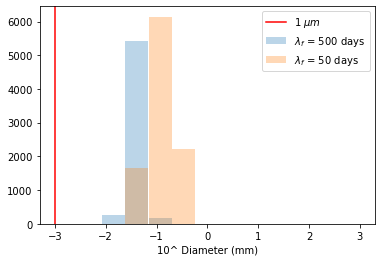

In [41]:
plt.bar(np.log10(binss[0:-1]), size_dist_500, align='edge', alpha=0.3, label=r'$\lambda_f$ = 500 days', width=0.45)
plt.bar(np.log10(binss[0:-1]), size_dist_50, align='edge', alpha=0.3, label=r'$\lambda_f$ = 50 days', width=0.45)

plt.axvline(-3, label=r"1 $\mu m$", color='red')
plt.xlabel('10^ Diameter (mm)')
plt.legend()
#

In [281]:
inMLD = {}


for ft in tqdm([500]):
    sim = xr.open_zarr(f'/storage/shared/oceanparcels/output_data/data_Claudio/set_17/set17_{ft}.zarr')
    sim = sim.compute()
    aux = np.array(sim['mld'] > sim['z'])
    aux = np.sum(aux, axis=0)

    inMLD[ft] = aux



100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.10s/it]


In [18]:
for ft in [50, 500, 5000, 50000]:
    plt.plot(time[:-6], inMLD[ft][:-10], label=ft)
    
plt.ylabel('Number of particles')
plt.xlabel('Time')
plt.title('Particles at Surface')
plt.legend()

NameError: name 'inMLD' is not defined

In [19]:
# <50 frag timescale

time_dim = 4856
ft = 50
sim = xr.open_zarr(f'/storage/shared/oceanparcels/output_data/data_Claudio/set_17/set17_{ft}.zarr')
sim = sim.compute()
nano = sim.where(sim.diameter < 1e-6, drop=True)
hist_counts = np.zeros((52, time_dim))

for i, fr in enumerate(range(0, 898, 1)):
    x = np.histogram(-nano['z'][:,fr].dropna('traj'), bins=bins,  density=False)
    hist_counts[:, i] = x[0]
#     plt.close()

    total_particles = np.sum(hist_counts, axis=0)
    
statz[ft] = hist_counts
counts[ft] = total_particles
    

/tmp/ipykernel_15005/2686824107.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax[1].pcolormesh(x, y, b/counts[50], cmap=color_map, vmin = 0, vmax=0.2)
/tmp/ipykernel_15005/2686824107.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax[2].pcolormesh(x, y, a/counts[500], cmap=color_map, vmin = 0, vmax=0.2)
/tmp/ipykernel_15005/2686824107.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is dep

Text(0.5, 1.0, 'Nanoparticles (50-1000 $nm$) in the water column')

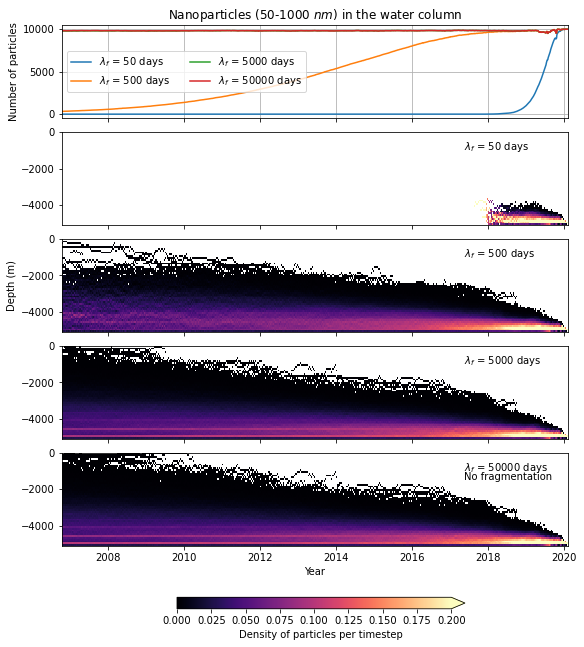

In [20]:
x, y = np.meshgrid(time, bins[1:])

fig, ax = plt.subplots(ncols=1, nrows=5, figsize=(8, 8),
                       sharex=True, constrained_layout=True)

for ft in [50, 500, 5000, 50000]:
    ax[0].plot(time, counts[ft],label=f'$\lambda_f$ = {ft} days')
ax[0].legend(ncol=2, loc='center left')
    
ax[0].set_ylabel('Number of particles')
# ax[1].set_ylabel('Number of particles')  
ax[2].set_ylabel('Depth (m)')  
ax[4].set_xlabel('Year') 
ax[0].grid()

color_map = 'magma'

b = np.ma.masked_equal(statz[50], 0)
im1 = ax[1].pcolormesh(x, y, b/counts[50], cmap=color_map, vmin = 0, vmax=0.2)
ax[1].text(17300, -1000, '$\lambda_f$ = 50 days')

a = np.ma.masked_equal(statz[500], 0)
im1 = ax[2].pcolormesh(x, y, a/counts[500], cmap=color_map, vmin = 0, vmax=0.2)
ax[2].text(17300, -1000, '$\lambda_f$ = 500 days')

# b = np.ma.masked_equal(statz[2500], 0)
# im2= ax[2].pcolormesh(x, y, b/counts[2500], cmap=color_map, vmin = 0, vmax=0.2)
# ax[2].text(17300, -1000, '$\lambda_f$ = 2500 days')


c = np.ma.masked_equal(statz[5000], 0)
im3 = ax[3].pcolormesh(x, y, c/counts[5000], cmap=color_map, vmin = 0, vmax=0.2)
ax[3].text(17300, -1000, '$\lambda_f$ = 5000 days')

d = np.ma.masked_equal(statz[50000], 0)
im4 = ax[4].pcolormesh(x, y, d/counts[50000], cmap=color_map, vmin = 0, vmax=0.2)
ax[4].text(17300, -1000, '$\lambda_f$ = 50000 days')
ax[4].text(17300, -1500, 'No fragmentation')

bar_ax = fig.add_axes([0.3, -0.05, 0.5, 0.02])
# ax[5].axis('off')
cbar = fig.colorbar(im3, cax=bar_ax, orientation='horizontal',extend='max', label='Density of particles per timestep')
# ax[0].pcolormesh(x, y, -hist_counts, cmap='viridis')
ax[0].set_title('Nanoparticles (50-1000 $nm$) in the water column')
# plt.savefig('../figs/frag_t_Vdist_nano.png', dpi=300)

In [21]:
big_dist = {}
for ft in [500,5000, 50000]:
    dist = {}
    for i in [7, 11,15, 19]:
        date = np.datetime64(f'20{i:02d}-12-31 12:00')
        year = f'20{(i+1):02d}'#np.datetime_as_string(date, unit='Y')
        a = np.where(x[0] == date)[0][0]

        dist[year] = statz[ft][:,a]
        
    big_dist[ft] = dist
    

In [22]:
f = stats.gaussian_kde(big_dist[ft]['2008'])

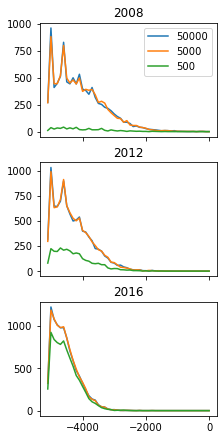

In [23]:
fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(3, 6),
                       sharex=True, constrained_layout=True)
x_data = y[:,0]

for ft in [50000 ,5000, 500]:
    for i, year in enumerate(['2008', '2012', '2016']):
#     f = stats.gaussian_kde(big_dist[ft]['2008'])
        ax[i].plot(x_data, big_dist[ft][year], label=ft)
        ax[i].set_title(year)
        ax[0].legend()


# Distance from sampling location

In [24]:
def haversine_distance_two(point_A, point_B):
    """Calculates the great circle distance between two points
    on the Earth.
    Parameters
    ----------
    point_A: tuple
        containing the (latitude, longitude) in decimal degrees coordinates of
        point A.
    point_B: tuple
        containing the (latitude, longitude) in decimal degrees coordinates of
        point B.
    Returns
    -------
    km: float
        the distance in km between point A and point B
    """
    lat1, lon1 = point_A
    lat2, lon2 = point_B
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km


In [26]:
nano

<xarray.Dataset>
Dimensions:           (traj: 10000, obs: 898)
Dimensions without coordinates: traj, obs
Data variables: (12/19)
    Kz                (traj, obs) float32 5.271e-05 6.009e-05 ... nan nan
    abs_salinity      (traj, obs) float32 34.74 34.74 34.74 ... nan nan nan
    cons_temperature  (traj, obs) float32 0.7279 0.7254 0.7221 ... nan nan nan
    density           (traj, obs) float32 1.028e+03 1.028e+03 ... nan nan
    diameter          (traj, obs) float64 5.05e-08 5.05e-08 5.05e-08 ... nan nan
    in_motion         (traj, obs) float64 1.0 1.0 1.0 1.0 ... nan nan nan nan
    ...                ...
    u                 (traj, obs) float32 4.618e-07 4.043e-07 ... nan nan
    v                 (traj, obs) float32 -5.266e-07 -3.972e-07 ... nan nan
    v_s               (traj, obs) float32 0.0 4.756e-10 4.756e-10 ... nan nan
    w                 (traj, obs) float32 2.774e-05 -0.0003397 ... nan nan
    w_k               (traj, obs) float32 0.0 0.0 0.0 0.0 ... nan nan nan nan
    z                 (traj, obs) float64 5.1e+03 5.119e+03 ... nan nan
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        v2.3.0-303-gd31c5f32

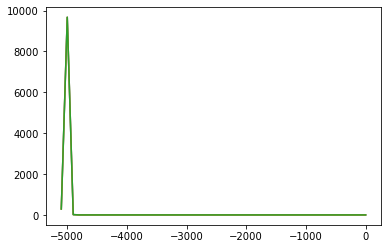

In [181]:
x_data = y[:,0]

for ft in [50000 ,5000, 500]:
#     f = stats.gaussian_kde(big_dist[ft]['2008'])
    plt.plot(x_data, big_dist[ft]['2020'])

In [104]:
dist['2008'].shape

(52,)

In [24]:
statz[500][0:10]

array([[0.000e+00, 9.990e+03, 9.631e+03, ..., 6.000e+00, 6.000e+00,
        7.000e+00],
       [1.000e+04, 1.000e+01, 3.690e+02, ..., 1.700e+01, 1.900e+01,
        1.800e+01],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.200e+01, 1.000e+01,
        9.000e+00],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 2.600e+01, 2.700e+01,
        2.600e+01],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.800e+01, 1.700e+01,
        1.700e+01],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.400e+01, 1.500e+01,
        1.400e+01]])

0 5000
1 2500
2 500


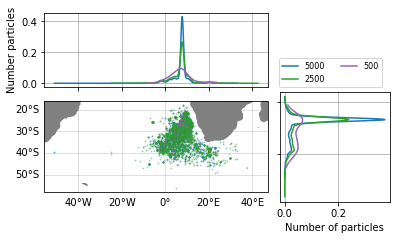

In [29]:
frame = 0
n_day = 360

fig = plt.figure()
gs = fig.add_gridspec(3, 2,  width_ratios=(6.1, 3), height_ratios=(2, 3, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.07, hspace=0.07)

ax = plt.subplot(gs[1, 0], projection=ccrs.PlateCarree())
# ax.set_extent((-45, 46, -52, -16))
ax.add_feature(cfeature.LAND,facecolor='#808080', zorder=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5)
gl.right_labels = False
gl.top_labels = False

ax_lon = plt.subplot(gs[0, 0], sharex=ax)
ax_lon.grid()
ax_lon.set_xticklabels([])
ax_lon.set_ylabel('Number particles')
# ax_lon.set_ylim(-5000, 0)

ax_lat = plt.subplot(gs[1, 1], sharey=ax)
ax_lat.grid()
ax_lat.set_yticklabels([])
ax_lat.set_xlabel('Number of particles')


ax_void = plt.subplot(gs[0, 1], sharey=ax)
ax_void.axis('off')


size_point = 0.7
frame = -1

frag_times = [5000, 2500, 500]

colormap='tab10'
x_colors = np.linspace(0, 0.4, len(frag_times))
colors = cm.get_cmap(colormap)(x_colors)

for i, ft in enumerate(frag_times):
    print(i, ft)
    sim = xr.open_zarr(f'/storage/shared/oceanparcels/output_data/data_Claudio/set_15/set15_{ft}.zarr/')
    suf = sim.where(sim.diameter < 1e-6, drop=True)
    
    xmin = suf['lon'][:,-1].dropna(dim='traj').min().values
    xmax = suf['lon'][:,-1].dropna(dim='traj').max().values
    ymin = suf['lat'][:,-1].dropna(dim='traj').min().values
    ymax = suf['lat'][:,-1].dropna(dim='traj').max().values
    x_range = np.linspace(xmin, xmax, 500)
    y_range = np.linspace(ymin, ymax, 500)
    
    kernel_lon = stats.gaussian_kde(suf['lon'][:,-1].dropna(dim='traj'))
    kernel_lat = stats.gaussian_kde(suf['lat'][:,-1].dropna(dim='traj'))
    
    kde_lon = kernel_lon(x_range)
    kde_lat = kernel_lat(y_range)
    
    n_surf_part = suf['lon'][:,-1].dropna(dim='traj').shape[0]
    
    ax.scatter(suf['lon'][:,frame], suf['lat'][:,frame], color=colors[i], zorder=4, s=1, alpha=0.3)

    ax_lon.plot(x_range, kde_lon, color=colors[i], label=ft)
    ax_lat.plot(kde_lat, y_range, color=colors[i])
    
ax_lon.legend(loc=(1.05, 0.), ncol=2, fontsize=8)

plt.savefig('../figs/frag_t_Hdist_nano.png', dpi=300)

## all particles

In [ ]:
time = np.linspace(0, 3650, 3651)

/tmp/ipykernel_209784/3803715408.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax[1].pcolormesh(x, y, a/counts_all[500], cmap='jet')
/tmp/ipykernel_209784/3803715408.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2= ax[2].pcolormesh(x, y, b/counts_all[2500], cmap='jet')
/tmp/ipykernel_209784/3803715408.py:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify t

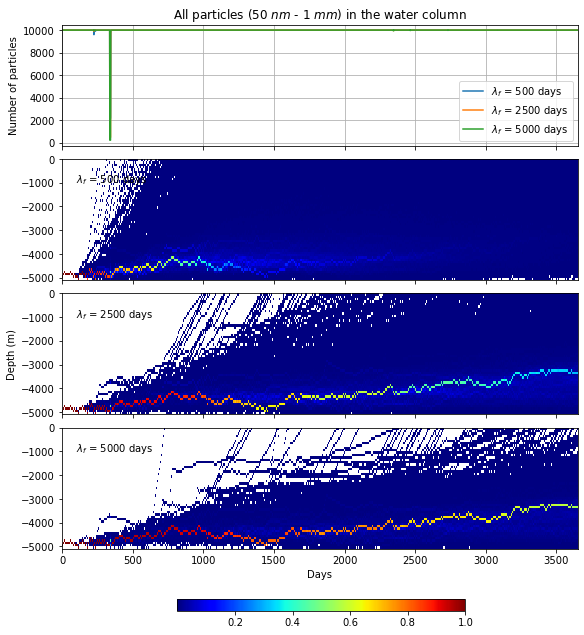

In [96]:
x, y = np.meshgrid(time, bins[1:])

fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(8, 8),
                       sharex=True, constrained_layout=True)

for ft in [500, 2500, 5000]:
    ax[0].plot(time, counts_all[ft],label=f'$\lambda_f$ = {ft} days')
    ax[0].legend()
    

ax[0].set_ylabel('Number of particles')
# ax[1].set_ylabel('Number of particles')  
ax[2].set_ylabel('Depth (m)')  
ax[3].set_xlabel('Days') 

ax[0].grid()

# plt.text()
a = np.ma.masked_equal(statz_all[500], 0)
im1 = ax[1].pcolormesh(x, y, a/counts_all[500], cmap='jet')
ax[1].text(100, -1000, '$\lambda_f$ = 500 days')

b = np.ma.masked_equal(statz_all[2500], 0)
im2= ax[2].pcolormesh(x, y, b/counts_all[2500], cmap='jet')
ax[2].text(100, -1000, '$\lambda_f$ = 2500 days')


c = np.ma.masked_equal(statz_all[5000], 0)
im3 = ax[3].pcolormesh(x, y, c/counts_all[5000], cmap='jet')
ax[3].text(100, -1000, '$\lambda_f$ = 5000 days')


bar_ax = fig.add_axes([0.3, -0.05, 0.5, 0.02])

cbar = fig.colorbar(im3, cax=bar_ax, orientation='horizontal')
# ax[0].pcolormesh(x, y, -hist_counts_all, cmap='viridis')
ax[0].set_title('All particles (50 $nm$ - 1 $mm$) in the water column')
plt.savefig('../figs/frag_t_Vdist_all.png', dpi=300)

0 5000


ValueError: zero-size array to reduction operation fmin which has no identity

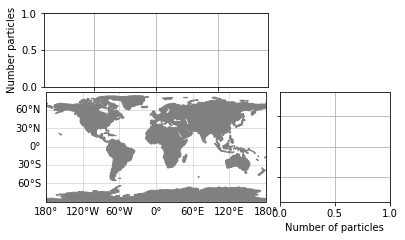

In [234]:
frame = 0
n_day = 360

fig = plt.figure()
gs = fig.add_gridspec(3, 2,  width_ratios=(6.1, 3), height_ratios=(2, 3, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.07, hspace=0.07)

ax = plt.subplot(gs[1, 0], projection=ccrs.PlateCarree())
# ax.set_extent((-45, 46, -52, -16))
ax.add_feature(cfeature.LAND,facecolor='#808080', zorder=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5)
gl.right_labels = False
gl.top_labels = False

ax_lon = plt.subplot(gs[0, 0], sharex=ax)
ax_lon.grid()
ax_lon.set_xticklabels([])
ax_lon.set_ylabel('Number particles')
# ax_lon.set_ylim(-5000, 0)

ax_lat = plt.subplot(gs[1, 1], sharey=ax)
ax_lat.grid()
ax_lat.set_yticklabels([])
ax_lat.set_xlabel('Number of particles')


ax_void = plt.subplot(gs[0, 1], sharey=ax)
ax_void.axis('off')


size_point = 0.7
frame = -1

frag_times = [5000, 2500, 500]

colormap='tab10'
x_colors = np.linspace(0, 0.4, len(frag_times))
colors = cm.get_cmap(colormap)(x_colors)

for i, ft in enumerate(frag_times):
    print(i, ft)
    suf = xr.open_zarr(f'/storage/shared/oceanparcels/output_data/data_Claudio/set_15/set15_{ft}.zarr/')
#     suf = sim.where(sim.diameter < 1e-6, drop=True)
    
    xmin = suf['lon'][:,-1].dropna(dim='traj').min().values
    xmax = suf['lon'][:,-1].dropna(dim='traj').max().values
    ymin = suf['lat'][:,-1].dropna(dim='traj').min().values
    ymax = suf['lat'][:,-1].dropna(dim='traj').max().values
    x_range = np.linspace(xmin, xmax, 500)
    y_range = np.linspace(ymin, ymax, 500)
    
    kernel_lon = stats.gaussian_kde(suf['lon'][:,-1].dropna(dim='traj'))
    kernel_lat = stats.gaussian_kde(suf['lat'][:,-1].dropna(dim='traj'))
    
    kde_lon = kernel_lon(x_range)
    kde_lat = kernel_lat(y_range)
    
    n_surf_part = suf['lon'][:,-1].dropna(dim='traj').shape[0]
    
    ax.scatter(suf['lon'][:,frame], suf['lat'][:,frame], color=colors[i], zorder=4, s=2, alpha=0.6)

    ax_lon.plot(x_range, kde_lon, color=colors[i], label=ft)
    ax_lat.plot(kde_lat, y_range, color=colors[i])
    
ax_lon.legend(loc=(1.05, 0.), ncol=2, fontsize=8)

# plt.savefig('../figs/frag_t_Hdist_nano.png', dpi=300)